In [1]:
import pandas as pd
import geopandas as gpd
import folium
from shapely.geometry import Polygon, Point, LineString
import pandas as pd
import geopandas as gpd
import folium
from IPython.display import Image
import selenium.webdriver
import shapely.geometry
import osmnx as ox
import pyproj
from geojson.feature import Feature, FeatureCollection
from shapely.geometry import Point, Polygon, LineString
import h3
import json

In [2]:
import os
cwd = os.getcwd()
os.chdir(os.path.join(cwd,'..\..\..'))
import ExMAS.main
import ExMAS.utils

from ExMAS.utils import inData as inData

In [3]:
params = ExMAS.utils.get_config('ExMAS/data/configs/my_config.json') # load the default 
params.paths.dumps = 'hexes'
params.times.patience = 1200
params.simTime = 4
params.parallel.nThread = 4
params.parallel.nReplications = 20

In [4]:
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph
inData = ExMAS.utils.load_albatross_csv(inData, params, sample=True)

01-12-20 17:40:46-INFO-Initializing pairwise trip shareability between 200 and 200 trips.
01-12-20 17:40:46-INFO-creating combinations
01-12-20 17:40:46-INFO-39800	 nR*(nR-1)
01-12-20 17:40:46-INFO-3771	departure compatibility
01-12-20 17:40:46-INFO-1227	origins shareability
01-12-20 17:40:46-INFO-212	utility for i
01-12-20 17:40:47-INFO-46	utility for j
01-12-20 17:40:47-INFO-56	LIFO pairs
01-12-20 17:40:47-INFO-Reduction of feasible pairs by 99.86%


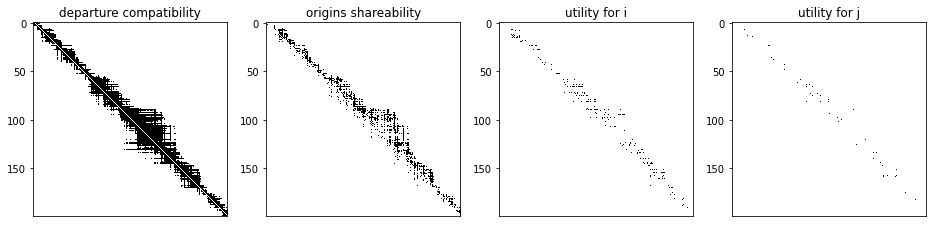

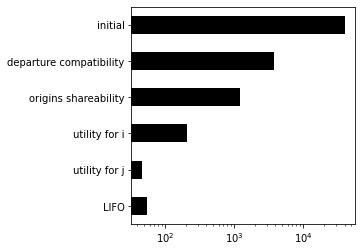

01-12-20 17:40:53-INFO-Degree 2 	Completed
01-12-20 17:40:53-INFO-trips to extend at degree 2 : 102
01-12-20 17:40:53-INFO-At degree 2 feasible extensions found out of 0 searched
01-12-20 17:40:53-INFO-Degree 3 	Completed
01-12-20 17:40:53-INFO-No more trips to exted at degree 3
01-12-20 17:40:53-INFO-Matching 200 trips to 302 rides in order to min u_veh


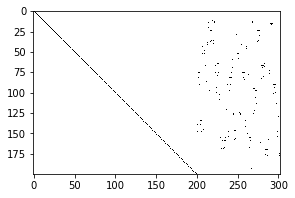

01-12-20 17:40:55-INFO-Problem solution: Optimal. 
Total costs for single trips:         98,124 
reduced by matching to:               93,382
01-12-20 17:40:55-INFO-Calculations  completed
01-12-20 17:40:55-INFO-DotMap(VehHourTrav=93052, VehHourTrav_ns=98124, PassHourTrav=102837, PassHourTrav_ns=98124, PassUtility=1484.9361, PassUtility_ns=1522.0005, mean_lambda=0.13737362032503841, revenue_s=103030.2, revenue_ns=147186.0, Fare_Discount=-0.30000000000000004, nR=200, SINGLE=156, PAIRS=22, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.21999999999999997, fleet_size_nonshared=20.0, fleet_size_shared=18.0, lambda_shared=0.13737362032503841)


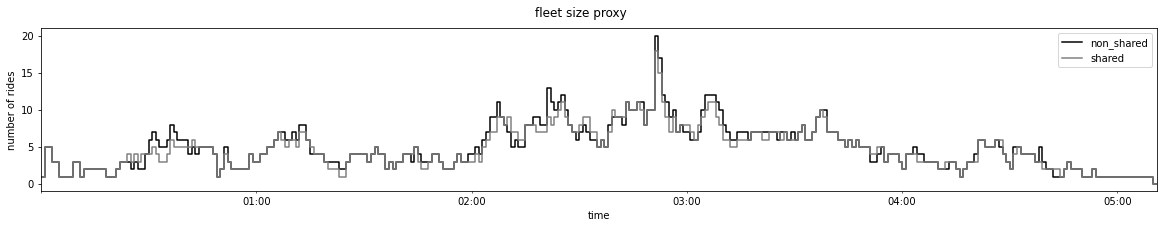

In [5]:
inData = ExMAS.main(inData, params, plot = True)

In [6]:
resop = pd.DataFrame(index =range(len(inData.sblts.requests)))
resop = resop.fillna(0)

In [27]:
def plot_hex_map(inData,res, APERTURE_SIZE = 9, threshold = 1, col = 'change_in_u'):
    res['change_in_u'] = inData.sblts.requests.u-inData.sblts.requests.u_sh
    orig = inData.requests.origin
    res['x'] = orig.reset_index(drop=True)
    res['y'] = orig.reset_index(drop=True)
    res['x'] = res['x'].apply(lambda row: inData.nodes.loc[row].x)
    res['y'] = res['y'].apply(lambda row: inData.nodes.loc[row].y)
    res['hex_o_{}'.format(APERTURE_SIZE)] = res.apply(lambda row: h3.geo_to_h3(row.y,row.x,APERTURE_SIZE),axis = 1) 
    trips = res
    
    col_geom = 'hex_o_{}'.format(APERTURE_SIZE)
    hexes = pd.Series(list(set(list(trips[col_geom].unique())+list(trips[col_geom].unique())))).to_frame(col_geom)
    hexes = hexes.set_index(col_geom)
    hexes[col_geom] = hexes.index.copy()
    hexes['nobs'] = trips.groupby(col_geom).size()
    hexes = hexes[hexes['nobs']>threshold]
    hexes['geom'] = hexes.apply(lambda x: {"type": "Polygon","coordinates": [h3.h3_to_geo_boundary(h = x[col_geom], geo_json = True)]}, axis = 1)
    aggr = trips.groupby(col_geom)[col]
    hexes['nobs'] = aggr.size()
    hexes[col] = aggr.mean()/60
    hexes[col+'_std'] = aggr.std()
    list_features = []
    for i, row in hexes.iterrows():
        feature = Feature(geometry = row["geom"],
                          id = row[col_geom],
                          properties = {"resolution": 9})
        list_features.append(feature)

    feat_collection = FeatureCollection(list_features)
    geojson_hexes = json.dumps(feat_collection)
    CENTER = list(inData.nodes.loc[inData.stats.center][['y','x']].values)
    tile = 'cartodbpositron'
    base_map = folium.Map(location=CENTER, zoom_start=13,tiles=tile, zoomControl =  False)
    bins = [0, 0.4,0.8, 1,1.4,1.8, 2,2.4,2.8, 3]
    m = folium.Choropleth(geo_data = geojson_hexes,data = hexes, columns = [col_geom,col],key_on ="feature.id",
            fill_color='Blues', control = False, bins = bins,
            fill_opacity=0.7, line_opacity=0.1).add_to(base_map)
    return base_map

In [24]:
plot_hex_map(inData, resop, APERTURE_SIZE = 9)

KeyError: 'Blues'